# LAB 8 - Review Generation 

## Introduction

In this Lab we are going to perform Text Generation to create reviews from a overall score and the label of the product using...

## Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import nltk
from rouge_score import rouge_scorer
from transformers import MT5Tokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq
from datasets import Dataset
import os


2024-05-06 14:42:06.238178: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load the data

In [2]:
# Load the data from the Excel file if there is no pickle file

if not os.path.exists('data.pkl'):
    print('Loading data from Excel file')
    data = pd.read_excel('ExercisesTest_v2.xlsx')
    
    # Create a pickle file to store the data and load it quickly
    data.to_pickle('data.pkl')

else:
    print('Loading data from pickle file')
    data = pd.read_pickle('data.pkl')

Loading data from pickle file


In [3]:
data.head()

,reviewTime,reviewerID,reviewerName,reviewText,summary,overall,category
0,"11 11, 2014",AZVP3R4R7375V,J. Grace,Just as strong as the full sized remote,Five Stars,5,Home
1,"03 28, 2018",A3HX9GNVO81ZM2,Allglad,....so Im getting right to the issues.\n\n1. Y...,Just Junk,5,Home
2,"01 31, 2018",A14CB9RNB93PFU,David w clinkinbeard,I'll be the first to admit that I was skeptica...,I love this gun,5,Home
3,"10 5, 2017",A37O92U4BC1QKP,M,Just buy these instead of purchasing the over-...,and hold up fine! Excellent and so happy to ju...,5,Automotive
4,"06 27, 2016",AZD9KQ5DYJ9A3,Cody,Works perfectly have it mounted to the hood of...,Works perfectly!!!,5,Automotive


## Data Statisctics

In [4]:
# Check the columns, the data types of the columns and number of entries
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378236 entries, 0 to 378235
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   reviewTime    378236 non-null  object
 1   reviewerID    378236 non-null  object
 2   reviewerName  378178 non-null  object
 3   reviewText    378085 non-null  object
 4   summary       378152 non-null  object
 5   overall       378236 non-null  int64 
 6   category      378236 non-null  object
dtypes: int64(1), object(6)
memory usage: 20.2+ MB


In [5]:
# Check if there are any missing values
data.isnull().sum()

reviewTime        0
reviewerID        0
reviewerName     58
reviewText      151
summary          84
overall           0
category          0
dtype: int64

In [6]:
# Remove the rows with missing values
data = data.dropna()

# Remove the rows where the review or the summary is not a string
data = data[(data['reviewText'].apply(type) == str) & (data['summary'].apply(type) == str)]

# Check the number of entries after removing the missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 377952 entries, 0 to 378235
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   reviewTime    377952 non-null  object
 1   reviewerID    377952 non-null  object
 2   reviewerName  377952 non-null  object
 3   reviewText    377952 non-null  object
 4   summary       377952 non-null  object
 5   overall       377952 non-null  int64 
 6   category      377952 non-null  object
dtypes: int64(1), object(6)
memory usage: 23.1+ MB


In [7]:
# Check the unique values of the categorical column
data['category'].unique()

array(['Home', 'Automotive'], dtype=object)

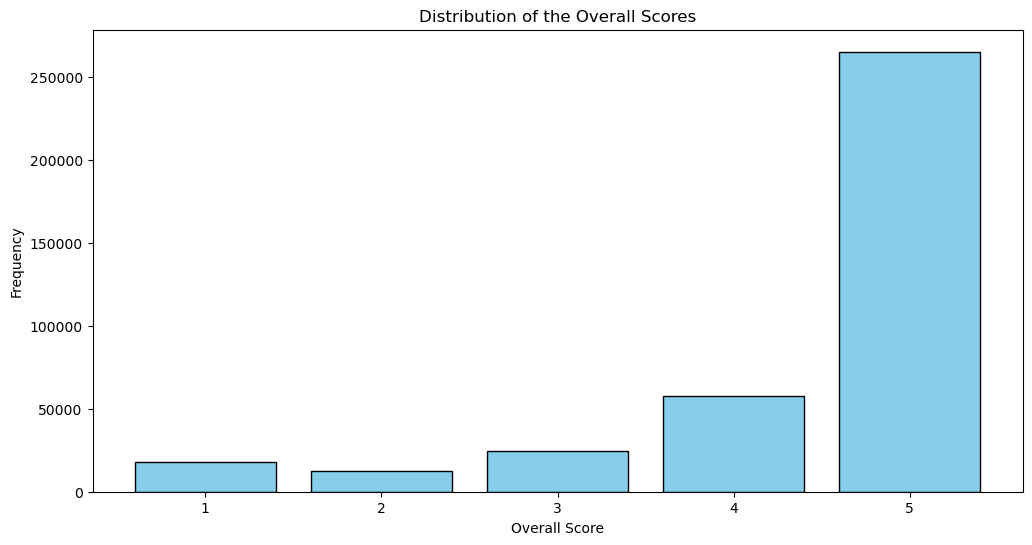

In [8]:
# Bar Plot of the distribution of the overall distribution
plt.figure(figsize=(12, 6))
bins = np.arange(0.5, 6.5, 1)  # This creates bins edges at 0.5, 1.5, 2.5, 3.5, 4.5, 5.5
# Plotting the histogram with specified bins
plt.hist(data['overall'], bins=bins, color='skyblue', edgecolor='black', rwidth=0.8)
# Setting x-ticks to be at the center of each bar
plt.xticks(np.arange(1, 6, 1))  # Positions the x-ticks at 1, 2, 3, 4, 5
plt.title('Distribution of the Overall Scores')
plt.xlabel('Overall Score')
plt.ylabel('Frequency')
plt.show()

In [9]:
# Check the mean, median, mode and standard deviation of the overall scores
mean = data['overall'].mean()
median = data['overall'].median()
mode = data['overall'].mode()[0]
std = data['overall'].std()

print(f'Mean: {mean:.2f}')
print(f'Median: {median:.2f}')
print(f'Mode: {mode:.2f}')
print(f'Standard Deviation: {std:.2f}')


Mean: 4.43
Median: 5.00
Mode: 5.00
Standard Deviation: 1.07


Minimum Review Length: 1
Maximum Review Length: 27057
Minimum Summary Length: 1
Maximum Summary Length: 405
Average Review Length: 225.42
Average Summary Length: 23.89


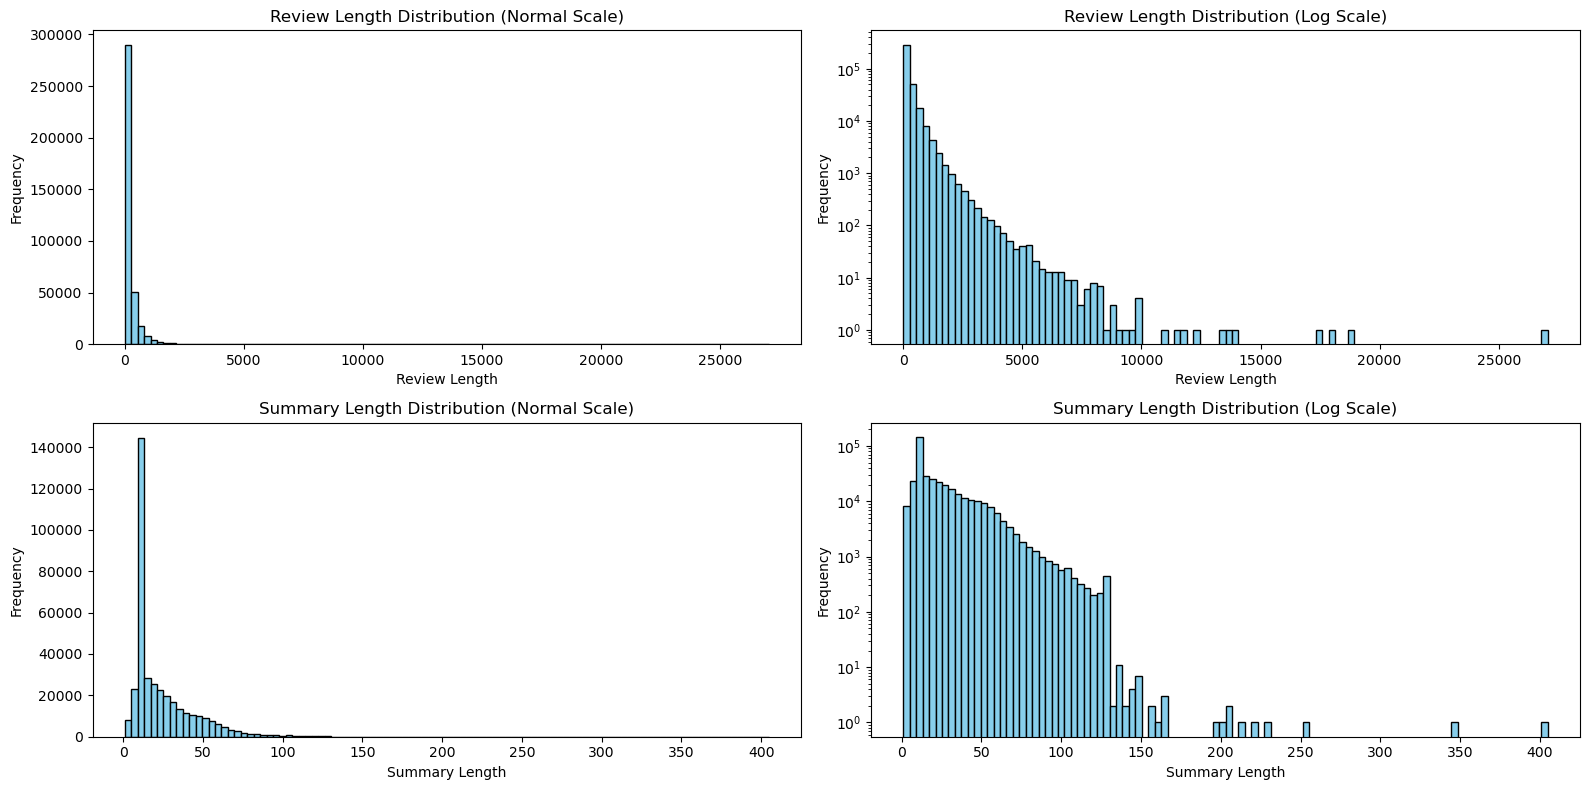

In [10]:
# Check the minimum and maximum length (number of characters) of the reviews and summary

data['review_length'] = data['reviewText'].apply(len)
data['summary_length'] = data['summary'].apply(len)

min_review_length = data['review_length'].min()
max_review_length = data['review_length'].max()
min_summary_length = data['summary_length'].min()
max_summary_length = data['summary_length'].max()

print(f'Minimum Review Length: {min_review_length}')
print(f'Maximum Review Length: {max_review_length}')
print(f'Minimum Summary Length: {min_summary_length}')
print(f'Maximum Summary Length: {max_summary_length}')
print(f'Average Review Length: {data["review_length"].mean():.2f}')
print(f'Average Summary Length: {data["summary_length"].mean():.2f}')

# Set up the figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))

# Plot for review length distribution in normal scale
axes[0, 0].hist(data['review_length'], bins=100, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Review Length Distribution (Normal Scale)')
axes[0, 0].set_xlabel('Review Length')
axes[0, 0].set_ylabel('Frequency')

# Plot for review length distribution in log scale
axes[0, 1].hist(data['review_length'], bins=100, color='skyblue', edgecolor='black')
axes[0, 1].set_title('Review Length Distribution (Log Scale)')
axes[0, 1].set_xlabel('Review Length')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_yscale('log')

# Plot for summary length distribution in normal scale
axes[1, 0].hist(data['summary_length'], bins=100, color='skyblue', edgecolor='black')
axes[1, 0].set_title('Summary Length Distribution (Normal Scale)')
axes[1, 0].set_xlabel('Summary Length')
axes[1, 0].set_ylabel('Frequency')

# Plot for summary length distribution in log scale
axes[1, 1].hist(data['summary_length'], bins=100, color='skyblue', edgecolor='black')
axes[1, 1].set_title('Summary Length Distribution (Log Scale)')
axes[1, 1].set_xlabel('Summary Length')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_yscale('log')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [11]:
for review, summary in zip(data['reviewText'], data['summary']):
    if len(review) < 10:
        print("Short Review: ", review)
    if len(summary) < 10:
        print("Short Summary: ", summary)

Short Summary:  Just Junk
Short Review:  good
Short Summary:  works
Short Review:  perfect
Short Summary:  no good
Short Summary:  best deal
Short Summary:  Great
Short Review:  Great!
Short Summary:  CRAP!
Short Summary:  good
Short Summary:  Love it
Short Review:  love it
Short Summary:  Good deal
Short Summary:  superb.
Short Summary:  great!
Short Summary:  good
Short Review:  Great!
Short Review:  so good
Short Summary:  Great!
Short Summary:  beutiful
Short Summary:  works
Short Summary:  Ok
Short Review:  Nice
Short Review:  great!!
Short Review:  Perfect!
Short Review:  GREAT !!
Short Summary:  One Star
Short Summary:  Buy now!
Short Summary:  Rotor
Short Summary:  Awesome
Short Summary:  Junk
Short Review:  good
Short Summary:  great
Short Review:  Excelent
Short Review:  Very good
Short Summary:  Very good
Short Review:  Perfect!
Short Summary:  Hi
Short Summary:  Perfecto!
Short Summary:  Viair 88p
Short Review:  great
Short Summary:  Good part
Short Review:  very good
Short

In [12]:
# Get one random sample review
review_text = data.sample(1)['reviewText'].values[0]
review_text

"What's there to talk about? Filter fit, oil is changed, saved $250, let's move on. :-/"

In [13]:
# Get one random sample summary
summary = data.sample(1)['summary'].values[0]
summary

'Looks nice but scratches easily'

In [14]:
duplicate_reviews = data['reviewText'].duplicated().sum()
duplicate_summaries = data['summary'].duplicated().sum()

print(f'Number of duplicate reviews: {duplicate_reviews}. Percentage: {duplicate_reviews / len(data) * 100:.2f}%')
print(f'Number of duplicate summaries: {duplicate_summaries}. Percentage: {duplicate_summaries / len(data) * 100:.2f}%')


Number of duplicate reviews: 48935. Percentage: 12.95%
Number of duplicate summaries: 174036. Percentage: 46.05%


In [15]:
n_same_review_summary = data[data['reviewText'] == data['summary']].shape[0]
print(f'Number of reviews that are the same as the summary: {n_same_review_summary}')

Number of reviews that are the same as the summary: 4778


## Preprocessing

MT5 Tokenizer

In [17]:
#Load the MT5 tokenizer which will be used to tokenize the data
tokenizer = MT5Tokenizer.from_pretrained('google/mt5-small')

# Tokenize the review and summary
data['review_tokens'] = data['reviewText'].apply(lambda x: tokenizer(x)['input_ids'])
data['summary_tokens'] = data['summary'].apply(lambda x: tokenizer(x)['input_ids'])

# Check the first 5 rows of the data
data[['review_tokens', 'summary_tokens']].head()

,review_tokens,summary_tokens
0,"[8690, 527, 16322, 527, 287, 3622, 259, 94142,...","[55400, 43996, 1]"
1,"[480, 260, 263, 268, 3865, 259, 13757, 4645, 2...","[8690, 259, 232522, 1]"
2,"[336, 277, 1578, 390, 287, 2262, 288, 40976, 5...","[336, 3869, 714, 22238, 1]"
3,"[8690, 6963, 259, 3824, 281, 15129, 304, 10075...","[305, 14934, 1150, 7495, 309, 57674, 305, 510,..."
4,"[66036, 5571, 484, 783, 609, 48525, 345, 288, ...","[66036, 5571, 484, 1976, 1]"


In [18]:
# show the tokens decoded of the first review
tokenizer.decode(data['review_tokens'][0])

'Just as strong as the full sized remote</s>'

NLTK Tokenizer



In [ ]:
# Tokenization of the reviews and summaries
nltk.download('punkt')

# Tokenize the review and summary
data['review_tokens'] = data['reviewText'].apply(nltk.word_tokenize)
data['summary_tokens'] = data['summary'].apply(nltk.word_tokenize)

# Check the first 5 rows of the data
data[['review_tokens', 'summary_tokens']].head()

[nltk_data] Downloading package punkt to /hhome/nlp2_g09/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,review_tokens,summary_tokens
0,"[Just, as, strong, as, the, full, sized, remote]","[Five, Stars]"
1,"[...., so, Im, getting, right, to, the, issues...","[Just, Junk]"
2,"[I, 'll, be, the, first, to, admit, that, I, w...","[I, love, this, gun]"
3,"[Just, buy, these, instead, of, purchasing, th...","[and, hold, up, fine, !, Excellent, and, so, h..."
4,"[Works, perfectly, have, it, mounted, to, the,...","[Works, perfectly, !, !, !]"


## Train-Test Split

Training Set: 302361 entries
Validation Set: 37795 entries


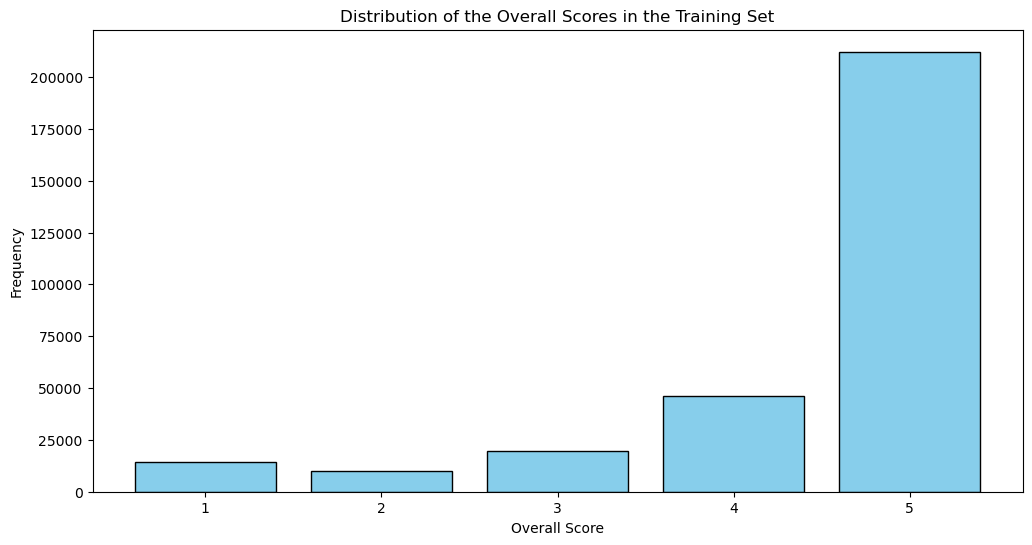

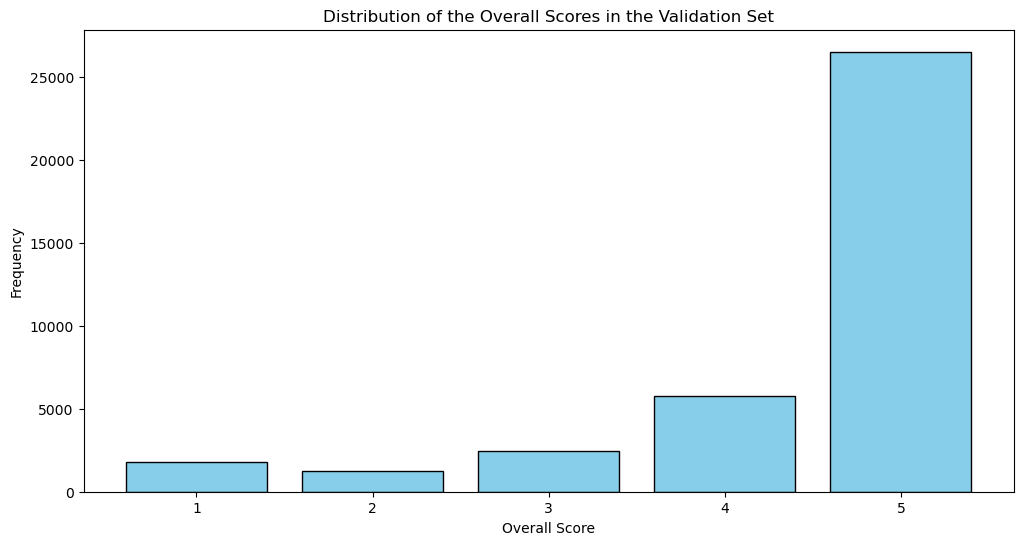

In [19]:
# Split the data into training and validation sets and keep equal proportions of the categories and overall scores in both sets
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
train_data, val_data = train_test_split(data, test_size=0.2, stratify=data[['category', 'overall']], random_state=42)

# Split the validation set into val and test sets
val_data, test_data = train_test_split(val_data, test_size=0.5, stratify=val_data[['category', 'overall']], random_state=42)

# Check the number of entries in the training and validation sets
print(f'Training Set: {train_data.shape[0]} entries')
print(f'Validation Set: {val_data.shape[0]} entries')

# Check the distribution of the overall scores in the training set
plt.figure(figsize=(12, 6))
bins = np.arange(0.5, 6.5, 1)  # This creates bins edges at 0.5, 1.5, 2.5, 3.5, 4.5, 5.5
# Plotting the histogram with specified bins
plt.hist(train_data['overall'], bins=bins, color='skyblue', edgecolor='black', rwidth=0.8)
# Setting x-ticks to be at the center of each bar
plt.xticks(np.arange(1, 6, 1))  # Positions the x-ticks at 1, 2, 3, 4, 5
plt.title('Distribution of the Overall Scores in the Training Set')
plt.xlabel('Overall Score')
plt.ylabel('Frequency')
plt.show()

# Check the distribution of the overall scores in the validation set
plt.figure(figsize=(12, 6))
bins = np.arange(0.5, 6.5, 1)  # This creates bins edges at 0.5, 1.5, 2.5, 3.5, 4.5, 5.5
# Plotting the histogram with specified bins
plt.hist(val_data['overall'], bins=bins, color='skyblue', edgecolor='black', rwidth=0.8)
# Setting x-ticks to be at the center of each bar
plt.xticks(np.arange(1, 6, 1))  # Positions the x-ticks at 1, 2, 3, 4, 5
plt.title('Distribution of the Overall Scores in the Validation Set')
plt.xlabel('Overall Score')
plt.ylabel('Frequency')
plt.show()


In [20]:
def one_hot_encode(data):
    # One-hot encode 'overall' score as a categorical feature
    overall_encoded = pd.get_dummies(data['overall'], prefix='overall')
    
    # One-hot encode 'category'
    category_encoded = pd.get_dummies(data['category'], prefix='category')
    
    # Concatenate the original data with the new one-hot encoded columns
    data = pd.concat([data, overall_encoded, category_encoded], axis=1)
    
    # Drop the original 'overall' and 'category' columns
    data.drop(['overall', 'category'], axis=1, inplace=True)
    
    return data

# Apply the function to your datasets
train_data = one_hot_encode(train_data)
val_data = one_hot_encode(val_data)
test_data = one_hot_encode(test_data)


In [21]:
train_data.head()

,reviewTime,reviewerID,reviewerName,reviewText,summary,review_length,summary_length,review_tokens,summary_tokens,overall_1,overall_2,overall_3,overall_4,overall_5,category_Automotive,category_Home
104109,"12 28, 2015",A1VNSTENTW7WHC,shoe,Works well as advertised.,Four Stars,25,10,"[66036, 2857, 527, 177334, 345, 260, 1]","[20913, 43996, 1]",False,False,False,True,False,False,True
165574,"10 29, 2015",A2GSRJZAVU0Y0H,JimR,"I have only used it a couple of times, but it ...","I have only used it a couple of times, ...",171,42,"[336, 783, 2469, 4165, 609, 259, 262, 14566, 3...","[336, 783, 2469, 4165, 609, 259, 262, 14566, 3...",False,False,False,True,False,False,True
37271,"12 10, 2016",A2NV8HZ0N6HAVB,Big d,I do commercial hvac and refrigeration and to ...,So I love the tool,225,18,"[336, 342, 20868, 9871, 297, 305, 90964, 2746,...","[1525, 336, 3869, 287, 16080, 1]",False,False,False,False,True,False,True
87361,"03 28, 2016",A2DG8PH0DXDB3F,mark hepburn,I was trying to upgrade the quality of the lin...,"Good fit, not heavy as expected",455,31,"[336, 639, 6557, 347, 288, 50488, 287, 7814, 3...","[8204, 7075, 261, 776, 259, 39852, 527, 259, 2...",False,True,False,False,False,True,False
127875,"06 17, 2018",A3GO9047XZ2W1K,Jimmy Reinhardt,I love it,Five Stars,9,10,"[336, 3869, 609, 1]","[55400, 43996, 1]",False,False,False,False,True,False,True


In [22]:
# Using the following columns
columns = ['review_tokens', 'overall_1', 'overall_2', 'overall_3', 'overall_4', 'overall_5', 'category_Automotive', 'category_Home']

# Convert Train DataFrame to Dataset
train_dataset = Dataset.from_pandas(train_data[columns])

# Convert Validation DataFrame to Dataset
val_dataset = Dataset.from_pandas(val_data[columns])

# Convert Test DataFrame to Dataset
test_dataset = Dataset.from_pandas(test_data)

# Show the first 5 rows of the training dataset
train_dataset[0:5]

{'review_tokens': [[66036, 2857, 527, 177334, 345, 260, 1],
  [336,
   783,
   2469,
   4165,
   609,
   259,
   262,
   14566,
   304,
   9502,
   261,
   1156,
   609,
   12122,
   263,
   288,
   390,
   259,
   2364,
   2857,
   3785,
   260,
   2953,
   14934,
   639,
   281,
   259,
   262,
   259,
   70577,
   22238,
   65032,
   261,
   609,
   259,
   24083,
   259,
   9191,
   259,
   262,
   5485,
   304,
   12077,
   1156,
   609,
   259,
   145345,
   345,
   259,
   262,
   259,
   2364,
   11092,
   74086,
   260,
   1],
  [336,
   342,
   20868,
   9871,
   297,
   305,
   90964,
   2746,
   305,
   288,
   783,
   259,
   262,
   16080,
   533,
   5169,
   263,
   714,
   259,
   27009,
   339,
   259,
   2364,
   259,
   123452,
   260,
   47012,
   276,
   259,
   185101,
   24691,
   281,
   1037,
   7334,
   259,
   3361,
   259,
   262,
   28746,
   6338,
   8185,
   336,
   277,
   282,
   259,
   13757,
   351,
   259,
   262,
   259,
   39064,
   260,
   1525,


## Model's Fine-Tuninng

In [23]:
def encode(examples):
    # Prepare the input text by including the score and category in a structured way
    input_text = [f"score1: {score1}  score2: {score2} score3: {score3} score4: {score4} score5: {score5} category_automotive: {cat1} category_home {cat2} review: {review}"
                    for score1, score2, score3, score4, score5, cat1, cat2, review in zip(
                        examples['overall_1'],
                        examples['overall_2'],
                        examples['overall_3'],
                        examples['overall_4'],
                        examples['overall_5'],
                        examples['category_Automotive'],
                        examples['category_Home'],
                        examples['review_tokens'])]

    # Tokenize the inputs
    model_inputs = tokenizer(input_text, max_length=512, truncation=True, padding='max_length')
    
    return model_inputs

# Assuming your DataFrame columns are correctly named and organized
train_dataset = train_dataset.map(encode, batched=True)
val_dataset = val_dataset.map(encode, batched=True)

# Show the first 5 rows of the training dataset
train_dataset[0:1]

Map:   0%|          | 0/302361 [00:00<?, ? examples/s]

Map:   0%|          | 0/37795 [00:00<?, ? examples/s]

{'review_tokens': [[66036, 2857, 527, 177334, 345, 260, 1]],
 'overall_1': [False],
 'overall_2': [False],
 'overall_3': [False],
 'overall_4': [True],
 'overall_5': [False],
 'category_Automotive': [False],
 'category_Home': [True],
 '__index_level_0__': [104109],
 'input_ids': [[18575,
   353,
   267,
   259,
   72548,
   18575,
   338,
   267,
   259,
   72548,
   18575,
   328,
   267,
   259,
   72548,
   18575,
   410,
   267,
   38583,
   18575,
   428,
   267,
   259,
   72548,
   27736,
   290,
   146949,
   267,
   259,
   72548,
   27736,
   290,
   5688,
   38583,
   4302,
   267,
   126805,
   230618,
   261,
   259,
   202017,
   261,
   145154,
   261,
   45455,
   53503,
   261,
   76017,
   261,
   29892,
   261,
   259,
   31028,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
  

In [24]:
from datasets import load_metric

# Load the model from the Hugging Face model hub
model = AutoModelForSeq2SeqLM.from_pretrained('google/mt5-small')

device = 'cuda:0' if torch.cuda.is_available() else "cpu"
model.to(device)

# Define the data collator
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# Function to compute ROUGE scores as metrics
def compute_metrics(eval_pred):
    rouge = load_metric("rouge")
    logits, labels = eval_pred
    predictions = torch.argmax(logits, dim=-1)
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Replace -100 in the labels as we can't decode them
    decoded_labels = [label.replace(tokenizer.pad_token, '') for label in decoded_labels]
    result = rouge.compute(predictions=decoded_preds, references=decoded_labels)
    return {key: value.mid.fmeasure for key, value in result.items()}

# Training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    #train_dataset=tokenized_train_dataset,
    #eval_dataset=tokenized_test_dataset,
    weight_decay=0.01,
    save_total_limit=5,
    num_train_epochs=5,
    
    predict_with_generate=True
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train the model

trainer.train()

# Evaluate the model
evaluation_results = trainer.evaluate()
print(evaluation_results)

/hhome/nlp2_g09/anaconda3/lib/python3.11/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: neildlf (nlp_2024). Use `wandb login --relogin` to force relogin


ValueError: You have to specify either decoder_input_ids or decoder_inputs_embeds